In [65]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import re

In [71]:
image_dir = "/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/red_z_res/wr140-mhd-l7n256/proj/"

In [72]:
fits_files = sorted(os.listdir(image_dir))
fits_files.sort(key=lambda test_string : list(
        map(int, re.findall(r'\d+', test_string))))

In [74]:
for file in fits_files[230:250]:
    hdul = fits.open(os.path.join(image_dir, file))
    data = hdul[10].data

    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(data, cmap="inferno")
    plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.savefig(file[:-4] + ".png", bbox_inches="tight", pad_inches=0)
    plt.close()
    
    

In [19]:
# hdul = fits.open('/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/red_z_res/wr140-hydro-l7n128/proj/wr140_hydro_cool_d3l7n128_XZ_img.00126976.fits')
# hdul = fits.open("/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/red_z_res/wr140-mhd-l7n256/proj/wr140_mhd_cool_d3l7n256_XY_img.00526336.fits")
hdul = fits.open("/mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/red_z_res/wr140-mhd-l7n256/proj/XY_proj/wr140_mhd_cool_d3l7n256_XY_img.00475136.fits")

hdul.info()

Filename: /mnt/massive-stars/data/thomas_simulations/wr140-sims/covertex_start/red_z_res/wr140-mhd-l7n256/proj/XY_proj/wr140_mhd_cool_d3l7n256_XY_img.00475136.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  Proj_SurfaceMass    1 PrimaryHDU       9   (1024, 1024)   float64   
  1  Proj_NeutralDens    1 ImageHDU         8   (1024, 1024)   float64   
  2  Proj_IonizedDens    1 ImageHDU         8   (1024, 1024)   float64   
  3  Proj_EmissionMeasure    1 ImageHDU         8   (1024, 1024)   float64   
  4  Proj_XRAY_g00p1keV    1 ImageHDU         8   (1024, 1024)   float64   
  5  Proj_XRAY_g00p2keV    1 ImageHDU         8   (1024, 1024)   float64   
  6  Proj_XRAY_g00p3keV    1 ImageHDU         8   (1024, 1024)   float64   
  7  Proj_XRAY_g00p5keV    1 ImageHDU         8   (1024, 1024)   float64   
  8  Proj_XRAY_g01p0keV    1 ImageHDU         8   (1024, 1024)   float64   
  9  Proj_XRAY_g02p0keV    1 ImageHDU         8   (1024, 1024)   float64   
 10  Proj_XRAY_g05

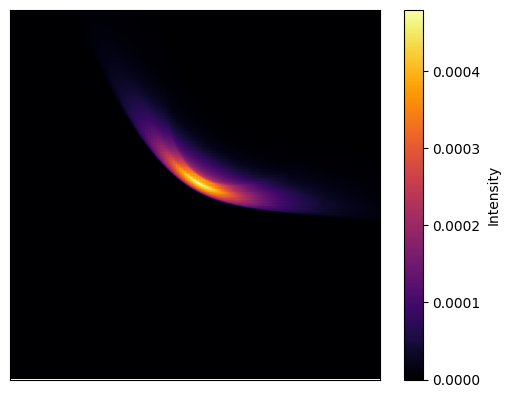

In [55]:
""" Display the image data with Matplotlib """

plt.figure()
plt.imshow(hdul[9].data-hdul[10].data, cmap='inferno')
plt.colorbar(location='right', label = 'Intensity')
plt.xlim(274, 1024-274)
plt.ylim(1024-274, 274)
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
plt.show()